In [127]:
import pandas as pd
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import torch.optim as optim
from plotnine import ggplot, aes, geom_point, geom_line, ggtitle, ylab, xlab

In [128]:
# Import Data
folder_path = "data/crypto"
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

dfs = []
for file in all_files:
    df = pd.read_csv(file, usecols=["Symbol", "Date", "Close"])
    dfs.append(df)

# Combine all files
securities = pd.concat(dfs, ignore_index=True)

# Pivot to wide format
sec_wide = securities.pivot(index="Date", columns="Symbol", values="Close")

# Remove the "Symbol" column name
sec_wide.columns.name = None

# Remove unwanted columns safely
remove_cols = ['WBTC', 'USDT', 'USDC']
sec_wide = sec_wide.drop(columns=remove_cols)

# Parse Date as datetime
sec_wide.index = pd.to_datetime(sec_wide.index)

# Remove rows with any NaN values
sec_wide = sec_wide.dropna()

# Optional: reset index so Date becomes a column
sec_wide = sec_wide.reset_index()

print(sec_wide.head())

                 Date       AAVE       ADA      ATOM        BNB           BTC  \
0 2020-10-05 23:59:59  53.219243  0.097544  5.382198  28.659104  10793.339428   
1 2020-10-06 23:59:59  42.401599  0.092808  4.732915  27.714528  10604.405889   
2 2020-10-07 23:59:59  40.083976  0.093800  4.886457  27.704836  10668.968955   
3 2020-10-08 23:59:59  43.764463  0.096152  5.045788  27.705311  10915.685731   
4 2020-10-09 23:59:59  46.817744  0.101925  5.157042  28.445031  11064.457592   

        CRO      DOGE       DOT       EOS  ...       LINK        LTC  \
0  0.150009  0.002612  4.172700  2.529068  ...   9.623703  46.363226   
1  0.147198  0.002611  3.756162  2.693054  ...   8.779272  45.985530   
2  0.147583  0.002595  3.858798  2.646043  ...   8.957850  46.660479   
3  0.150626  0.002596  4.102642  2.609671  ...   9.508818  47.218381   
4  0.152428  0.002653  4.262468  2.645295  ...  10.346902  47.832955   

      MIOTA       SOL       TRX       UNI       XEM       XLM         XMR  \
0  

In [129]:
# Make target and features
base = 'BTC'
X = sec_wide.drop(columns=['Date', base])
y = sec_wide[base]

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Scale data
scalar_X = StandardScaler() # can be robustscler(), might be better
scalar_y = StandardScaler()

X = torch.tensor(scalar_X.fit_transform(X), dtype=torch.float32)
y = torch.tensor(scalar_y.fit_transform(y), dtype=torch.float32)

# Test-train split
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create DataLoaders
batch_size = 8
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [130]:
# Model
class LinearRegressionModel(nn.Module):
    def __init__ (self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False) # just a linear combination of inputs

    def forward(self, x):
        return self.linear(x) # no activation function, just linear
    
model = LinearRegressionModel(X.shape[1])

In [131]:
# Training Setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = nn.MSELoss()

In [132]:
# Training Loop
epochs = 100
# Define fractions per epoch (repeat if epochs > 9)
fractions = [1.0]*30 + [0.5]*30 + [0.25]*40
if epochs > len(fractions):
    # Extend the last fraction for remaining epochs
    fractions += [fractions[-1]]*(epochs - len(fractions))

for epoch in range(epochs):
    # Determine fraction for this epoch
    frac = fractions[epoch]
    n_samples = int(len(train_dataset) * frac)
    
    # Randomly select indices
    indices = np.random.choice(len(train_dataset), n_samples, replace=False)
    sampler = SubsetRandomSampler(indices)
    
    # Create a DataLoader for this epoch
    train_loader_epoch = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    
    # Training loop for this epoch
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader_epoch:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= n_samples  # average over sampled dataset
    
    # Evaluate on test set every 10 epochs
    if (epoch+1) % 10 == 0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_loss /= len(test_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{epochs}], fraction={frac}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [10/100], fraction=1.0, Train Loss: 0.0333, Test Loss: 0.0363
Epoch [20/100], fraction=1.0, Train Loss: 0.0212, Test Loss: 0.0255
Epoch [30/100], fraction=1.0, Train Loss: 0.0201, Test Loss: 0.0177
Epoch [40/100], fraction=0.5, Train Loss: 0.0195, Test Loss: 0.0112
Epoch [50/100], fraction=0.5, Train Loss: 0.0201, Test Loss: 0.0072
Epoch [60/100], fraction=0.5, Train Loss: 0.0188, Test Loss: 0.0067
Epoch [70/100], fraction=0.25, Train Loss: 0.0245, Test Loss: 0.0221
Epoch [80/100], fraction=0.25, Train Loss: 0.0204, Test Loss: 0.0216
Epoch [90/100], fraction=0.25, Train Loss: 0.0181, Test Loss: 0.0162
Epoch [100/100], fraction=0.25, Train Loss: 0.0167, Test Loss: 0.0151


In [133]:
# Extract Weights
raw_weights = model.linear.weight.detach().numpy().flatten()

# Rescale weights
weights = raw_weights * scalar_y.scale_ / scalar_X.scale_
print("Weights unscaled: ", weights)

Weights unscaled:  [-5.02232542e+00  4.82210024e+03 -8.52629381e+01 -3.00108067e+00
 -1.26855220e+03 -2.44146864e+04  1.94557225e+02 -3.32308094e+03
  4.94721853e+00 -3.71368243e+02  1.55089489e+02  5.60445780e+03
 -2.35918111e+02  8.16969317e+04  2.98727381e+02 -2.71225134e+03
  1.43195242e+04 -5.94170298e+00 -4.48926307e+03]


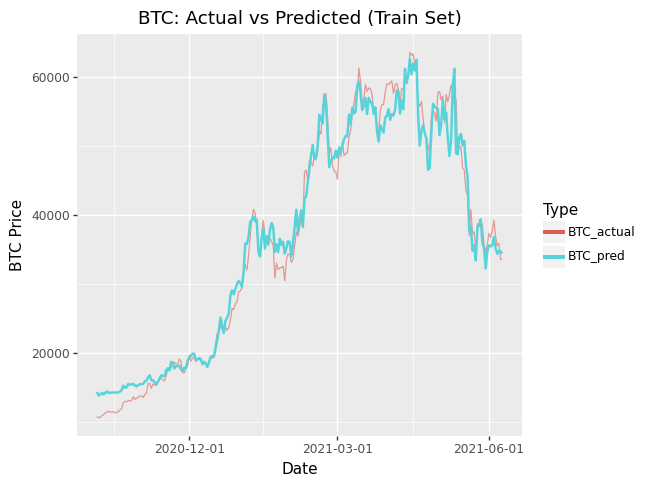

In [134]:
# Predict on train
model.eval()
y_train_pred_list = []

with torch.no_grad():
    for X_batch, _ in train_loader:
        y_pred_batch = model(X_batch)
        y_train_pred_list.append(y_pred_batch)

# Concatenate batches and inverse scale
y_train_pred = torch.cat(y_train_pred_list, dim=0).numpy()
y_train_pred_orig = scalar_y.inverse_transform(y_train_pred)
y_train_orig = scalar_y.inverse_transform(y_train.numpy())

# Plot
df_plot_train = pd.DataFrame({
    'Date': sec_wide['Date'][:split_idx].reset_index(drop=True),
    'BTC_actual': y_train_orig.flatten(),
    'BTC_pred': y_train_pred_orig.flatten()
})

# Melt the DataFrame so we can map actual vs predicted to color
df_melt_train = df_plot_train.melt(id_vars='Date', value_vars=['BTC_actual', 'BTC_pred'],
                                   var_name='Type', value_name='BTC')

# Plot with legend
p_train = (
    ggplot(df_melt_train, aes(x='Date', y='BTC', color='Type')) +
    geom_line(data=df_melt_train[df_melt_train['Type']=='BTC_actual'], alpha=0.6) +
    geom_line(data=df_melt_train[df_melt_train['Type']=='BTC_pred'], size=1) +
    ggtitle('BTC: Actual vs Predicted (Train Set)') +
    xlab('Date') +
    ylab('BTC Price')
)

p_train.draw()


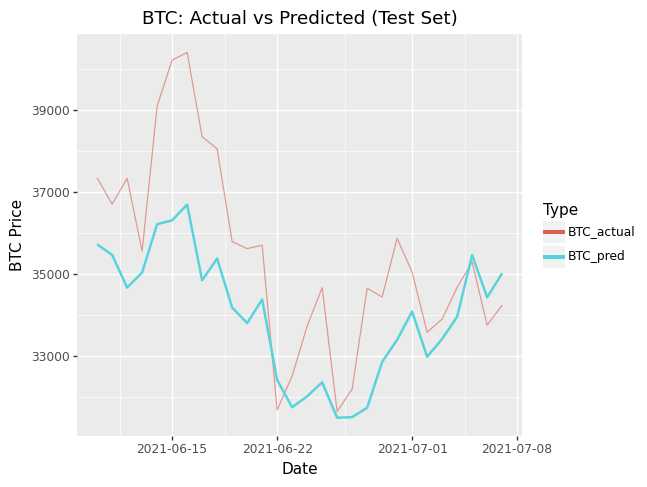

In [ ]:
# Predict on test
model.eval()
y_test_pred_list = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred_batch = model(X_batch)
        y_test_pred_list.append(y_pred_batch)

# Concatenate batches and inverse scale
y_test_pred = torch.cat(y_test_pred_list, dim=0).numpy()
y_test_pred_orig = scalar_y.inverse_transform(y_test_pred)
y_test_orig = scalar_y.inverse_transform(y_test.numpy())


# Plot
df_plot = pd.DataFrame({
    'Date': sec_wide['Date'][split_idx:].reset_index(drop=True),
    'BTC_actual': y_test_orig.flatten(),
    'BTC_pred': y_test_pred_orig.flatten()
})

# Melt the DataFrame so we can map actual vs predicted to color
df_melt = df_plot.melt(id_vars='Date', value_vars=['BTC_actual', 'BTC_pred'],
                       var_name='Type', value_name='BTC')

# Plot with legend
p = (
    ggplot(df_melt, aes(x='Date', y='BTC', color='Type')) +
    geom_line(data=df_melt[df_melt['Type']=='BTC_actual'], alpha=0.6) +
    geom_line(data=df_melt[df_melt['Type']=='BTC_pred'], size=1) +
    ggtitle('BTC: Actual vs Predicted (Test Set)') +
    xlab('Date') +
    ylab('BTC Price')
)
p.draw()

# TODO: Scaling requires a intercept or else prediction is too low, find fix